In [29]:
# Getting the dataset (MNIST https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html)

import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
                root="data",            # Root directory of data
                train=True,             # True for training data
                download=True,          # True to download the data
                transform=ToTensor(),   # How to transfor the data
                target_transform=None)  # How to transform the target labels

testing_data = datasets.FashionMNIST(
                root="data",
                train=False,
                download=True,
                transform=ToTensor(),
                target_transform=None)

print(f"Length of training data: {len(training_data)}")
print(f"Length of testing data: {len(testing_data)}")

Length of training data: 60000
Length of testing data: 10000


Image Shape: torch.Size([1, 28, 28])
Label: Ankle boot


(-0.5, 27.5, 27.5, -0.5)

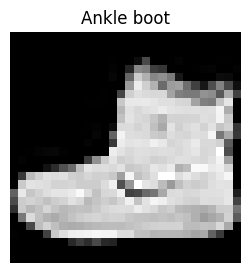

In [30]:
# Shape of an image ([colour channels, height, width])
# Each training data is a tuple containing the image tensor and label

image, label = training_data[0]
print(f"Image Shape: {image.shape}")
print(f"Label: {training_data.classes[label]}")

plt.figure(figsize=(3,3))
plt.imshow(image.squeeze(), cmap="gray")
plt.title(training_data.classes[label])
plt.axis(False)

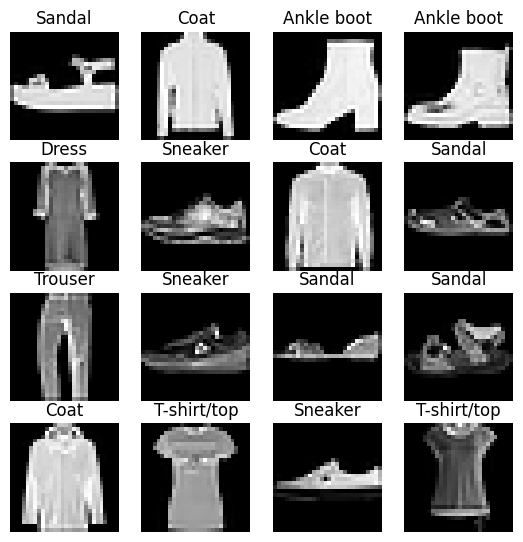

In [31]:
# Plot random images 
fig = plt.figure(figsize=(6.5, 6.5))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_index = torch.randint(0, len(training_data), size=[1]).item()
    image, label = training_data[random_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(training_data.classes[label])
    plt.axis(False)

(-0.5, 27.5, 27.5, -0.5)

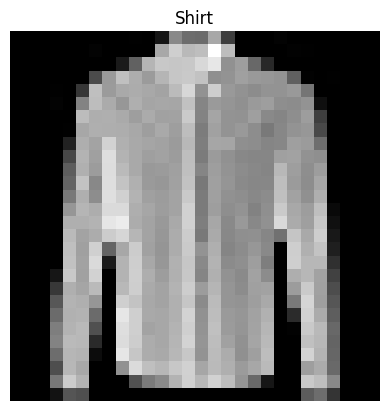

In [32]:
'''
Split massive data into batches

1. Computationally efficient.
2. Give neural networks more chances to update its gradient
'''
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=testing_data, batch_size=32, shuffle=False) # Easier to evaluate model if test data is in same order

train_feature_batch, train_label_batch = next(iter(train_dataloader))

random_index = torch.randint(0, len(train_feature_batch), size=[1]).item()
image, label = train_feature_batch[random_index], train_label_batch[random_index]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(training_data.classes[label])
plt.axis(False)

In [33]:
# Linear model for computer vision

device = "cuda" if torch.cuda.is_available() else "cpu"

class FashionMNIST(nn.Module):
    def __init__(self, input_features: int, hidden_units: int, output_features: int):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features))
        
    def forward(self, x):
        return self.linear_layer(x)
    
model_0 = FashionMNIST(input_features=28*28, hidden_units=10, output_features=len(training_data.classes)).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [34]:
def print_train_time(start: torch.float, end: torch.float, device: torch.device = None):
    ''' Prints the difference between training start time and training end time'''
    total = end - start
    print(f"Training time on {device}: {total:.3f} seconds")
    return total

In [35]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
import time

epochs = 3
torch.manual_seed(69)

train_time_start = time.time()
for epoch in tqdm(range(epochs)):
    # Training
    training_loss = 0

    # Loop through all batches
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model_0.train()

        y_pred = model_0(X)
        loss = loss_function(y_pred, y)
        training_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch % 500 == 0):
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples.")
        
    # Calculate average training loss
    training_loss /= len(train_dataloader)

    testing_loss, test_accuracy = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            test_pred = model_0(X_test)
            testing_loss += loss_function(test_pred, y_test)
            test_accuracy += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1)) # Call argmax on test_pred as it is in logits, use argmax to convert to predicted label

        testing_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)
    
    print(f"Training Loss: {training_loss:.3f} | Testing Loss: {testing_loss:.3f} | Testing Accuracy: {test_accuracy:.3f}")

train_time_end = time.time()
total_time_model_0 = print_train_time(start=train_time_start, end=train_time_end, device=str(next(model_0.parameters()).device))
        

  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0 / 60000 samples.
Looked at 16000 / 60000 samples.
Looked at 32000 / 60000 samples.
Looked at 48000 / 60000 samples.


 33%|███▎      | 1/3 [00:07<00:14,  7.11s/it]

Training Loss: 0.593 | Testing Loss: 0.580 | Testing Accuracy: 78.225
Looked at 0 / 60000 samples.
Looked at 16000 / 60000 samples.
Looked at 32000 / 60000 samples.
Looked at 48000 / 60000 samples.


 67%|██████▋   | 2/3 [00:14<00:07,  7.34s/it]

Training Loss: 0.479 | Testing Loss: 0.528 | Testing Accuracy: 81.230
Looked at 0 / 60000 samples.
Looked at 16000 / 60000 samples.
Looked at 32000 / 60000 samples.
Looked at 48000 / 60000 samples.


100%|██████████| 3/3 [00:21<00:00,  7.11s/it]

Training Loss: 0.457 | Testing Loss: 0.477 | Testing Accuracy: 83.237
Training time on cuda:0: 21.330 seconds


In [36]:
def eval_model(model: nn.Module, dataLoader: torch.utils.data.DataLoader, loss_function: nn.Module, accuracy_function):
    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        # Run each batch
        for X, y in tqdm(dataLoader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            # Accumulate loss and accuracy per batch
            loss += loss_function(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(dataLoader)            
        acc /= len(dataLoader)      

    return {"model_name": model.__class__.__name__, "model_loss": loss.item(), "model_accuracy": acc}      

In [37]:
# Non-linear model
class FashionMNISTv2(nn.Module):
    def __init__(self, input_features: int, hidden_units: int, output_features: int):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            nn.ReLU())
        
    def forward(self, x):
        return self.linear_layer(x)

In [38]:
model_1 = FashionMNISTv2(input_features=28*28, hidden_units=10, output_features=len(training_data.classes)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

def train_loop(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optim: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        # Set up device agnostic code
        X, y = X.to(device), y.to(device)

        # Pass the training data to model
        y_pred = model(X)

        # Calculate and accumulate loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # Logits to prediction labels

        optim.zero_grad()
        loss.backward()
        optim.step()
    
    # Divide total training loss and accuracy for average performance
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}% ")

def test_loop(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()
    
    with torch.inference_mode():
        for (X, y) in data_loader:
            X, y = X.to(device), y.to(device)
                
            # Pass testing data to model
            y_pred = model(X)

            # Calculate and accumulate loss and accuracy
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Testing Loss: {test_loss:.4f} | Testing Accuracy: {test_acc:.4f}% ")

In [39]:
torch.manual_seed(69)
epochs = 3

import time
train_time_start = time.time()

for epoch in tqdm(range(epochs)):
    print(f"------ Epoch: {epoch} ------")
    train_loop(model=model_1, data_loader=train_dataloader, loss_fn=loss_function, optim=optimizer, accuracy_fn=accuracy_fn, device=device)
    test_loop(model=model_1, data_loader=test_dataloader, loss_fn=loss_function, accuracy_fn=accuracy_fn, device=device)
    print()

train_time_end = time.time()
time_diff = print_train_time(train_time_start, train_time_end, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

------ Epoch: 0 ------
Training Loss: 0.9521 | Training Accuracy: 66.0700% 


 33%|███▎      | 1/3 [00:07<00:14,  7.50s/it]

Testing Loss: 0.8045 | Testing Accuracy: 69.2692% 

------ Epoch: 1 ------
Training Loss: 0.7064 | Training Accuracy: 74.0367% 


 67%|██████▋   | 2/3 [00:14<00:07,  7.44s/it]

Testing Loss: 0.7342 | Testing Accuracy: 72.6637% 

------ Epoch: 2 ------
Training Loss: 0.6129 | Training Accuracy: 77.5117% 


100%|██████████| 3/3 [00:23<00:00,  7.82s/it]

Testing Loss: 0.4829 | Testing Accuracy: 82.9073% 

Training time on cuda: 23.456 seconds


In [40]:
model_0_results = eval_model(model_0, test_dataloader, loss_function, accuracy_fn)
print(model_0_results)

100%|██████████| 313/313 [00:01<00:00, 239.52it/s]

{'model_name': 'FashionMNIST', 'model_loss': 0.476728618144989, 'model_accuracy': 83.23682108626198}


In [41]:
model_1_results = eval_model(model_1, test_dataloader, loss_function, accuracy_fn)
print(model_1_results)

100%|██████████| 313/313 [00:00<00:00, 316.84it/s]

{'model_name': 'FashionMNISTv2', 'model_loss': 0.4829476475715637, 'model_accuracy': 82.90734824281151}


In [42]:
# Convolutional Neural Network

class FashionMNISTv3(nn.Module):
    def __init__(self, input_neurons: int, hidden_neurons: int, output_neurons: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
                            nn.Conv2d(in_channels=input_neurons, out_channels=hidden_neurons, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=hidden_neurons, out_channels=hidden_neurons, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2))
        
        self.conv_block_2 = nn.Sequential(
                            nn.Conv2d(in_channels=hidden_neurons, out_channels=hidden_neurons, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(in_channels=hidden_neurons, out_channels=hidden_neurons, kernel_size=3, stride=1, padding=1),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2))
        
        self.output_layer = nn.Sequential(
                            nn.Flatten(),
                            nn.Linear(in_features=hidden_neurons*7*7, out_features=output_neurons))

    def forward(self, x):
        return self.output_layer(self.conv_block_2(self.conv_block_1(x)))
        # x = self.conv_block_1(x)
        # print(x.shape)
        # x = self.conv_block_2(x)
        # print(x.shape)
        # x = self.output_layer(x)
        # print(x.shape)
        return x

In [43]:
torch.manual_seed(69)

model_2 = FashionMNISTv3(input_neurons=1, hidden_neurons=10, output_neurons=len(training_data.classes)).to(device)
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

epochs = 3
train_time_start = time.time()

for epoch in tqdm(range(epochs)):
    print(f"------Epoch {epoch}------")
    train_loop(model=model_2, data_loader=train_dataloader, loss_fn=loss_func, optim=optim, accuracy_fn=accuracy_fn, device=device)
    test_loop(model=model_2, data_loader=test_dataloader, loss_fn=loss_func, accuracy_fn=accuracy_fn, device=device)

train_time_end = time.time()
time_diff = print_train_time(train_time_start, train_time_end, device=device)

model_2_results = eval_model(model=model_2, dataLoader=test_dataloader, loss_function=loss_func, accuracy_function=accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

------Epoch 0------
Training Loss: 0.5962 | Training Accuracy: 78.7550% 


 33%|███▎      | 1/3 [00:09<00:19,  9.93s/it]

Testing Loss: 0.4010 | Testing Accuracy: 85.5232% 
------Epoch 1------
Training Loss: 0.3629 | Training Accuracy: 86.9483% 


 67%|██████▋   | 2/3 [00:19<00:09,  9.96s/it]

Testing Loss: 0.3719 | Testing Accuracy: 86.3918% 
------Epoch 2------
Training Loss: 0.3300 | Training Accuracy: 88.0433% 


100%|██████████| 3/3 [00:29<00:00,  9.79s/it]


Testing Loss: 0.3748 | Testing Accuracy: 85.9525% 
Training time on cuda: 29.384 seconds


100%|██████████| 313/313 [00:00<00:00, 324.31it/s]


In [44]:
import pandas as pd

model_results_comparsion = pd.DataFrame([model_0_results, model_1_results, model_2_results])
model_results_comparsion

,model_name,model_loss,model_accuracy
0,FashionMNIST,0.476729,83.236821
1,FashionMNISTv2,0.482948,82.907348
2,FashionMNISTv3,0.374791,85.952476


In [45]:
def predict(model: torch.nn.Module,
            data: list,
            device: torch.device = device):
    
    pred_prob = []
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in data:
            # Add a batch dimension to data
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # Convert outputs to probabilities
            logits = model(sample)
            prob = torch.softmax(logits.squeeze(), dim=0)
            pred_prob.append(prob.cpu())

    # Stack the probabilites to turn list into tensor
    return torch.stack(pred_prob)

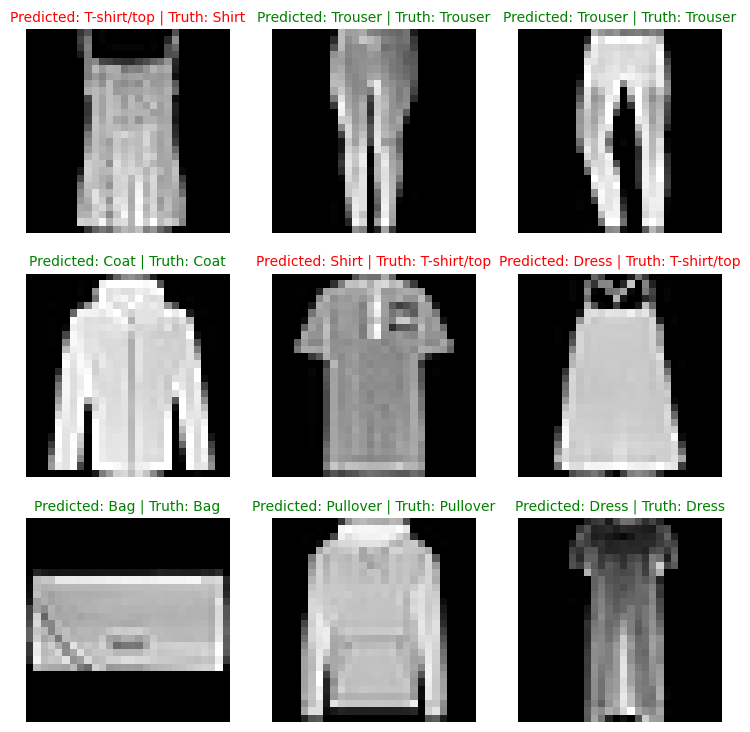

In [46]:
# Make predictions using modelv3
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(testing_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_prob = predict(model=model_2, data=test_samples, device=device)
pred_class = pred_prob.argmax(dim=1)

plt.figure(figsize=(9,9))
rows, cols = 3, 3

for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(rows, cols, i+1)

    # Show target image
    plt.imshow(sample.squeeze(), cmap="gray")

    pred_label = testing_data.classes[pred_class[i]]
    truth_label = testing_data.classes[test_labels[i]]
    
    title = f"Predicted: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title, fontsize=10, c="g")
    else: 
        plt.title(title, fontsize=10, c="r")

    plt.axis(False)

100%|██████████| 313/313 [00:01<00:00, 277.92it/s]


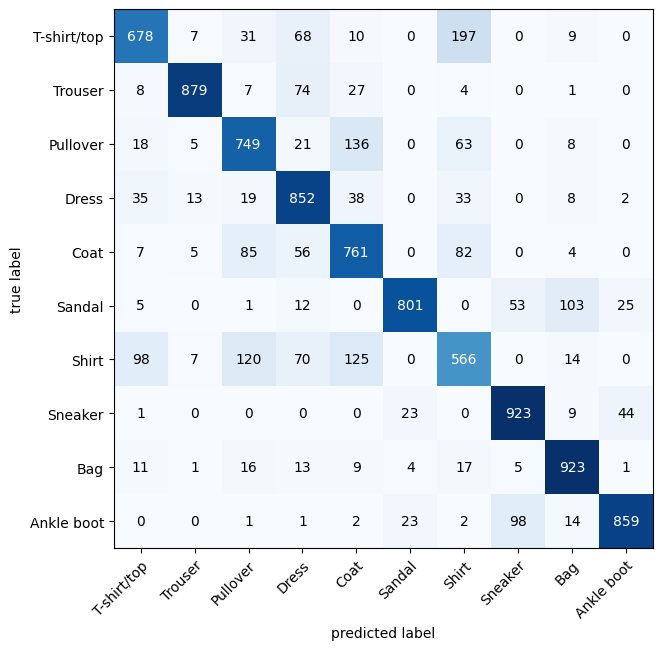

In [47]:
# Confusion Matrix to see how well the model predicts
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix 

y_pred = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)

        logits = model_2(X)
        pred = torch.softmax(logits.squeeze(), dim=0).argmax(dim=1)
        y_pred.append(pred.cpu())

pred_tensor = torch.cat(y_pred)

confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=len(training_data.classes))
confusion_matrix_tensor = confusion_matrix(preds=pred_tensor, target=testing_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix_tensor.numpy(), class_names=testing_data.classes, figsize=(10, 7))

In [48]:
# Saving trained model's state_dict() to file.
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "pytorch_vision_ex.ipynb"
model_save_path = model_path / model_name

torch.save(model_2.state_dict(), model_save_path)